In [1]:
import sys

sys.path.append("..")

import tensorflow as tf

import tensorflow_probability as tfp

import numpy as np

import GPyOpt

import argparse

from utils import tf_config, preprocess_data, search_algorithms, train, bnn_utils, outlier_utils, eeg_utils

import matplotlib.pyplot as plt

import gc

import os

from sklearn.model_selection import train_test_split, KFold

from scipy.stats import shapiro, ttest_ind

from scipy.signal import resample

import time

raw_eeg=True#time or frequency features? raw-time nonraw-frequency
resampling=True
resample_setting=["noresampling", "resampling"]
if(raw_eeg):
    analysis_setting="time"
else:
    analysis_setting="frequency"
dataset="01"
memory_limit=4000
n_individuals=8
interval_eeg=6

tf_config.set_seed(seed=42)
tf_config.setup_tensorflow(device="CPU", memory_limit=memory_limit)

with tf.device('/CPU:0'):
    train_data, val_data = preprocess_data.dataset(dataset, n_individuals=n_individuals, 
                                                   raw_eeg=raw_eeg,
                                                    interval_eeg=interval_eeg, 
                                                    ind_volume_fit=False,
                                                    standardize_fmri=True,
                                                    iqr=False,
                                                    verbose=True)
    eeg_train, fmri_train=train_data

I: Starting to Load Data
I: Finished Loading Data
I: Pairs Created


In [2]:
eeg_train.shape

(1746, 64, 3240, 1)

In [3]:
fmri_train.shape

(1746, 64, 64, 30, 1)

In [4]:
if(dataset=="01"):
    channel_names = eeg_utils.get_eeg_instance_01(0).ch_names
elif(dataset=="02"):
    channel_names = eeg_utils.channels_02

In [5]:

from scipy.signal import correlate
import time


i=0
start_time = time.time()

for individual in range(eeg_train.shape[0]):
    
    freqs_x_channels = None
    freqs_y_channels = None
    freqs_z_channels = None
    
    for channel in range(eeg_train.shape[1]):
        
        freqs_x = None
        freqs_y = None
        freqs_z = None
        
        if(raw_eeg):
            if(resampling):
                corr_x = correlate(resample(eeg_train[individual,channel,:,:], fmri_train[individual,:,30,15].shape[0])/np.linalg.norm(eeg_train[individual,channel,:]), 
                          fmri_train[individual,:,30,15]/np.linalg.norm(fmri_train[individual,:,30,15]))
                corr_y = correlate(resample(eeg_train[individual,channel,:,:], fmri_train[individual,30,:,15].shape[0])/np.linalg.norm(eeg_train[individual,channel,:]), 
                          fmri_train[individual,30,:,15]/np.linalg.norm(fmri_train[individual,30,:,15]))
                corr_z = correlate(resample(eeg_train[individual,channel,:,:], fmri_train[individual,30,30,:].shape[0])/np.linalg.norm(eeg_train[individual,channel,:]), 
                          fmri_train[individual,30,30,:]/np.linalg.norm(fmri_train[individual,30,30,:]))
            else:
                corr_x = correlate(eeg_train[individual,channel,:,:]/np.linalg.norm(eeg_train[individual,channel,:]), 
                          fmri_train[individual,:,30,15]/np.linalg.norm(fmri_train[individual,:,30,15]))
                corr_y = correlate(eeg_train[individual,channel,:,:]/np.linalg.norm(eeg_train[individual,channel,:]), 
                          fmri_train[individual,30,:,15]/np.linalg.norm(fmri_train[individual,30,:,15]))
                corr_z = correlate(eeg_train[individual,channel,:,:]/np.linalg.norm(eeg_train[individual,channel,:]), 
                          fmri_train[individual,30,30,:]/np.linalg.norm(fmri_train[individual,30,30,:]))

            
            if(type(freqs_x_channels) == type(None)):
                freqs_x_channels, freqs_y_channels, freqs_z_channels = np.zeros((eeg_train.shape[1], corr_x.shape[0])), np.zeros((eeg_train.shape[1], corr_y.shape[0])), np.zeros((eeg_train.shape[1], corr_z.shape[0]))
                freqs_x_channels_ttest, freqs_y_channels_ttest, freqs_z_channels_ttest = np.empty(shape=(eeg_train.shape[1], eeg_train.shape[0]*corr_x.shape[0])), np.empty(shape=(eeg_train.shape[1], eeg_train.shape[0]*corr_y.shape[0])), np.empty(shape=(eeg_train.shape[1], eeg_train.shape[0]*corr_z.shape[0]))
            
            corr_x = np.nan_to_num(corr_x)
            corr_y = np.nan_to_num(corr_y)
            corr_z = np.nan_to_num(corr_z)
            
            freqs_x_channels[channel,:] += corr_x[:,0]
            freqs_y_channels[channel,:] += corr_y[:,0]
            freqs_z_channels[channel,:] += corr_z[:,0]
            
            freqs_x_channels_ttest[channel,i*corr_x.shape[0]:(i+1)*corr_x.shape[0]] = corr_x[:,0].flatten()
            freqs_y_channels_ttest[channel,i*corr_y.shape[0]:(i+1)*corr_y.shape[0]] = corr_y[:,0].flatten()
            freqs_z_channels_ttest[channel,i*corr_z.shape[0]:(i+1)*corr_z.shape[0]] = corr_z[:,0].flatten()
            
        else:

            for frequency in range(eeg_train.shape[2]):
                corr_x = correlate(eeg_train[individual, channel, frequency,:]/np.linalg.norm(eeg_train[individual, channel, frequency,:]), 
                                   fmri_train[individual,:,30,15]/np.linalg.norm(fmri_train[individual,:,30,15]))
                corr_y = correlate(eeg_train[individual, channel, frequency,:]/np.linalg.norm(eeg_train[individual, channel, frequency,:]), 
                                   fmri_train[individual,30,:,15]/np.linalg.norm(fmri_train[individual,30,:,15]))
                corr_z = correlate(eeg_train[individual, channel, frequency,:]/np.linalg.norm(eeg_train[individual, channel, frequency,:]), 
                                   fmri_train[individual,30,30,:]/np.linalg.norm(fmri_train[individual,30,30,:]))

                if(freqs_x is None):
                    freqs_x, freqs_y, freqs_z = np.empty(shape=(eeg_train.shape[2],corr_x.shape[0])), np.empty(shape=(eeg_train.shape[2],corr_y.shape[0])), np.empty(shape=(eeg_train.shape[2],corr_z.shape[0]))


                freqs_x[frequency,:] = corr_x[:,0]
                freqs_y[frequency,:] = corr_y[:,0]
                freqs_z[frequency,:] = corr_z[:,0]

            freqs_x = np.nan_to_num(freqs_x)
            freqs_y = np.nan_to_num(freqs_y)
            freqs_z = np.nan_to_num(freqs_z)

            if(type(freqs_x_channels) == type(None)):
                freqs_x_channels, freqs_y_channels, freqs_z_channels = np.zeros((eeg_train.shape[1], eeg_train.shape[2], freqs_x.shape[1])), np.zeros((eeg_train.shape[1], eeg_train.shape[2], freqs_y.shape[1])), np.zeros((eeg_train.shape[1], eeg_train.shape[2], freqs_z.shape[1]))
                freqs_x_channels_ttest, freqs_y_channels_ttest, freqs_z_channels_ttest = np.empty(shape=(eeg_train.shape[1], eeg_train.shape[0]*eeg_train.shape[2]*freqs_x.shape[1])), np.empty(shape=(eeg_train.shape[1], eeg_train.shape[0]*eeg_train.shape[2]*freqs_y.shape[1])), np.empty(shape=(eeg_train.shape[1], eeg_train.shape[0]*eeg_train.shape[2]*freqs_z.shape[1]))

            freqs_x_channels[channel,:,:] += freqs_x
            freqs_y_channels[channel,:,:] += freqs_y
            freqs_z_channels[channel,:,:] += freqs_z

            freqs_x_channels_ttest[channel,i*freqs_x.shape[1]*eeg_train.shape[2]:(i+1)*freqs_x.shape[1]*eeg_train.shape[2]] = freqs_x.flatten()
            freqs_y_channels_ttest[channel,i*freqs_y.shape[1]*eeg_train.shape[2]:(i+1)*freqs_y.shape[1]*eeg_train.shape[2]] = freqs_y.flatten()
            freqs_z_channels_ttest[channel,i*freqs_z.shape[1]*eeg_train.shape[2]:(i+1)*freqs_z.shape[1]*eeg_train.shape[2]] = freqs_z.flatten()
            
    #channel increment after
    i+=1
    
    #if(individual % 50 == 0):
    print("Finished: ", individual+1, end="\r")
    
print("Took ", time.time()-start_time, "seconds")

Took  107.74462270736694 seconds


In [6]:
if(raw_eeg):
    freqs_x_mean = freqs_x_channels

    freqs_y_mean = freqs_y_channels

    freqs_z_mean = freqs_z_channels
else:
    freqs_x_mean = np.amax(freqs_x_channels, axis=2)

    freqs_y_mean = np.amax(freqs_y_channels, axis=2)

    freqs_z_mean = np.amax(freqs_z_channels, axis=2)
    
freqs_x_mean

array([[-0.00179887, -0.00403086, -0.00545415, ..., -0.0031715 ,
        -0.00251146, -0.00123211],
       [-0.00174273, -0.00264467, -0.00273302, ..., -0.00445832,
        -0.00414682, -0.00259112],
       [-0.00222768, -0.00435878, -0.00573743, ..., -0.00563396,
        -0.00389304, -0.00183281],
       ...,
       [ 0.00273045,  0.00536016,  0.00761093, ...,  0.00562276,
         0.0039831 ,  0.00191861],
       [-0.00137046, -0.00305077, -0.00379666, ..., -0.00148615,
        -0.00147483, -0.00067707],
       [ 0.00111398,  0.0011758 ,  0.00136982, ...,  0.00574352,
         0.00391886,  0.00215206]])

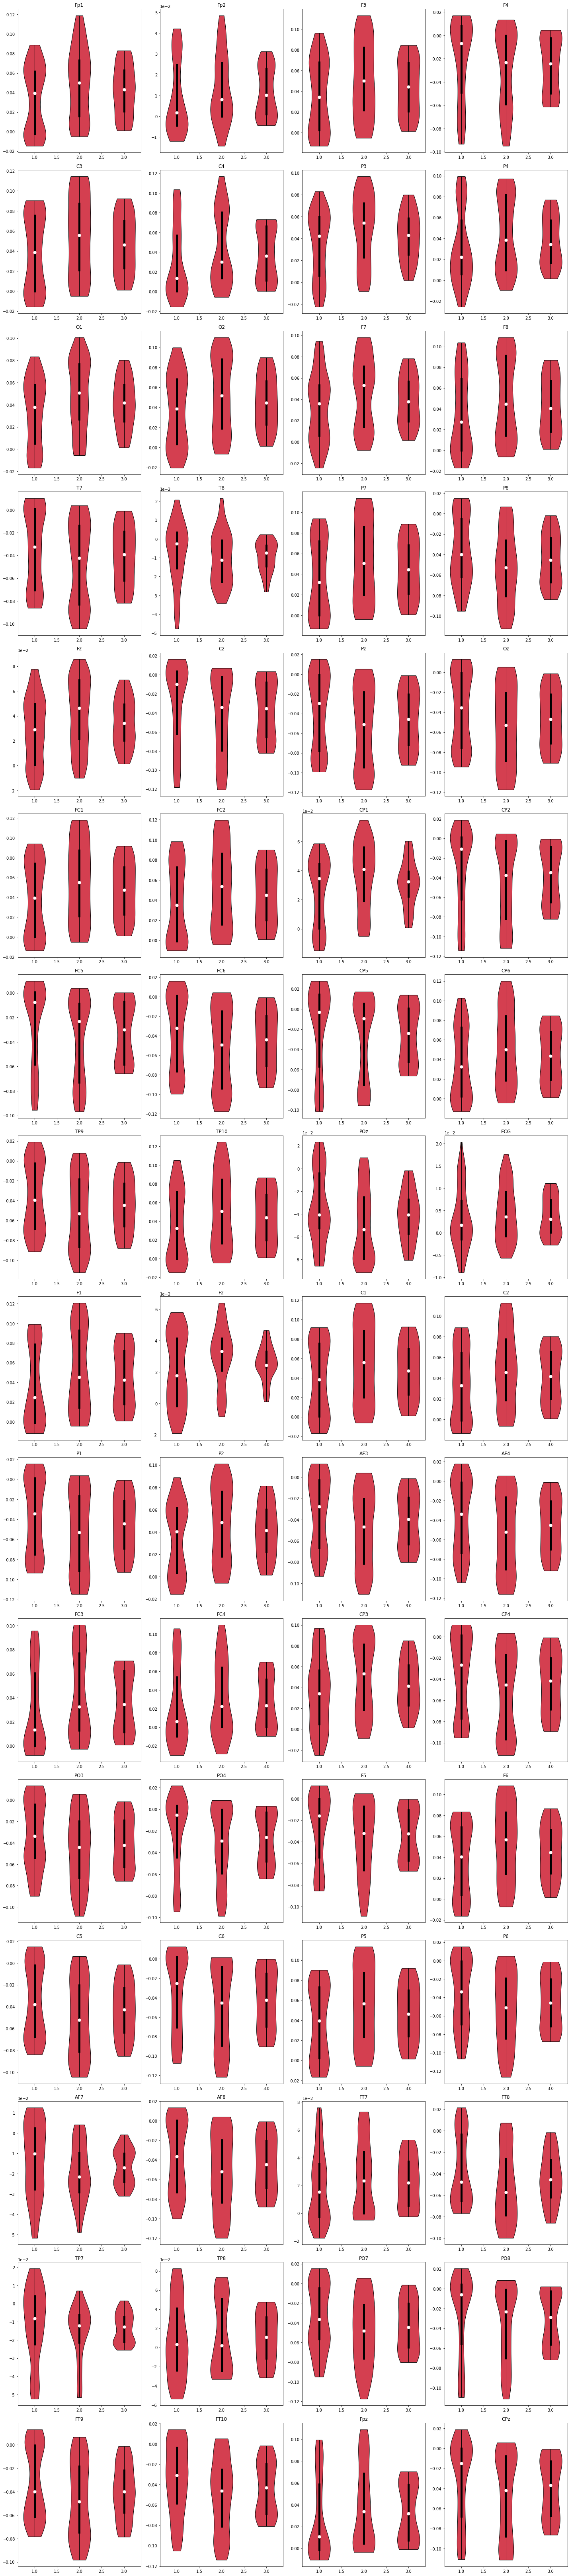

In [7]:
fig, axes = plt.subplots(eeg_train.shape[1]//4,4, figsize=(20,90))

i = 0
j = 0

for channel in range(eeg_train.shape[1]):
    
    if(j ==4):
        i+=1
        j=0
    parts = axes[i][j].violinplot([freqs_x_mean[channel,:], freqs_y_mean[channel,:], freqs_z_mean[channel,:]],
                           showmeans=False, showmedians=False,
            showextrema=False)
    
    if(np.mean([np.amax(freqs_x_mean[channel,:]), np.amax(freqs_y_mean[channel,:]), np.amax(freqs_z_mean[channel,:])]) < 0.2):
        facecolor='#D43F50'
    elif(np.mean([np.amax(freqs_x_mean[channel,:]), np.amax(freqs_y_mean[channel,:]), np.amax(freqs_z_mean[channel,:])]) < 0.4):
        facecolor='#ffcc00'
    else:
        facecolor="#66ff33"
    for pc in parts['bodies']:
        pc.set_facecolor(facecolor)
        pc.set_edgecolor('black')
        pc.set_alpha(1)


    quartile1_x, medians_x, quartile3_x = np.percentile(freqs_x_mean[channel,:], [25, 50, 75])
    quartile1_y, medians_y, quartile3_y = np.percentile(freqs_y_mean[channel,:], [25, 50, 75])
    quartile1_z, medians_z, quartile3_z = np.percentile(freqs_z_mean[channel,:], [25, 50, 75])
    
    quartile1 = [quartile1_x, quartile1_y, quartile1_z]
    medians = [medians_x, medians_y, medians_z]
    quartile3 = [quartile3_x, quartile3_y, quartile3_z]

    names = [1.0,2.0,3.0]
    axes[i][j].set_title(channel_names[channel])
    axes[i][j].scatter(names, medians, marker='o', color='white', s=50, zorder=3)
    axes[i][j].vlines(names, quartile1, quartile3, color='k', linestyle='-', lw=5)
    axes[i][j].vlines(names, [np.amin(freqs_x_mean[channel,:]), np.amin(freqs_y_mean[channel,:]), np.amin(freqs_z_mean[channel,:])], [np.amax(freqs_x_mean[channel,:]), np.amax(freqs_y_mean[channel,:]), np.amax(freqs_z_mean[channel,:])],color='k', linestyle='-', lw=1)
    axes[i][j].ticklabel_format(style="sci", scilimits=(-2,2))
    #plt.xticks([1.0,2.0,3.0], ["x-axis", "y-axis", "z-axis"])
    
    j+=1

plt.rc('font', family='serif')
plt.tight_layout()

if(dataset == "01"):
    fig.savefig("../../plots/stat_analysis/"+analysis_setting+"_"+resample_setting[int(resampling)]+"_violin_channels_ds000001.pdf", format="pdf")
elif(dataset == "02"):
    fig.savefig("../../plots/stat_analysis/"+analysis_setting+"_"+resample_setting[int(resampling)]+"_violin_channels_ds000002.pdf", format="pdf")
else:
    fig.savefig("../../plots/stat_analysis/"+analysis_setting+"_"+resample_setting[int(resampling)]+"_violin_channels_ds002158.pdf", format="pdf")

## Run t test

In [8]:
for channel in range(eeg_train.shape[1]):
    if(shapiro(freqs_x_channels_ttest[channel,:]).pvalue > 0.0):
        print("Normal distribution")
        
    if(shapiro(freqs_y_channels_ttest[channel,:]).pvalue > 0.0):
        print("Normal distribution")
        
    if(shapiro(freqs_z_channels_ttest[channel,:]).pvalue > 0.0):
        print("Normal distribution")

In [9]:
pvalue_img = np.zeros((3, eeg_train.shape[1], eeg_train.shape[1]))

for channel1 in range(eeg_train.shape[1]):
    for channel2 in range(eeg_train.shape[1]):
        
        pvalue_img[0, channel1, channel2] = ttest_ind(freqs_x_channels_ttest[channel1,:], freqs_x_channels_ttest[channel2,:])[1]
        pvalue_img[1, channel1, channel2] = ttest_ind(freqs_y_channels_ttest[channel1,:], freqs_y_channels_ttest[channel2,:])[1]
        pvalue_img[2, channel1, channel2] = ttest_ind(freqs_z_channels_ttest[channel1,:], freqs_z_channels_ttest[channel2,:])[1]
        

In [10]:
pvalue_img_pixels = (pvalue_img <= 0.05).astype("int32")
channel_names = eeg_utils.get_eeg_instance_01(0).ch_names
#pvalue_img_pixels = pvalue_img

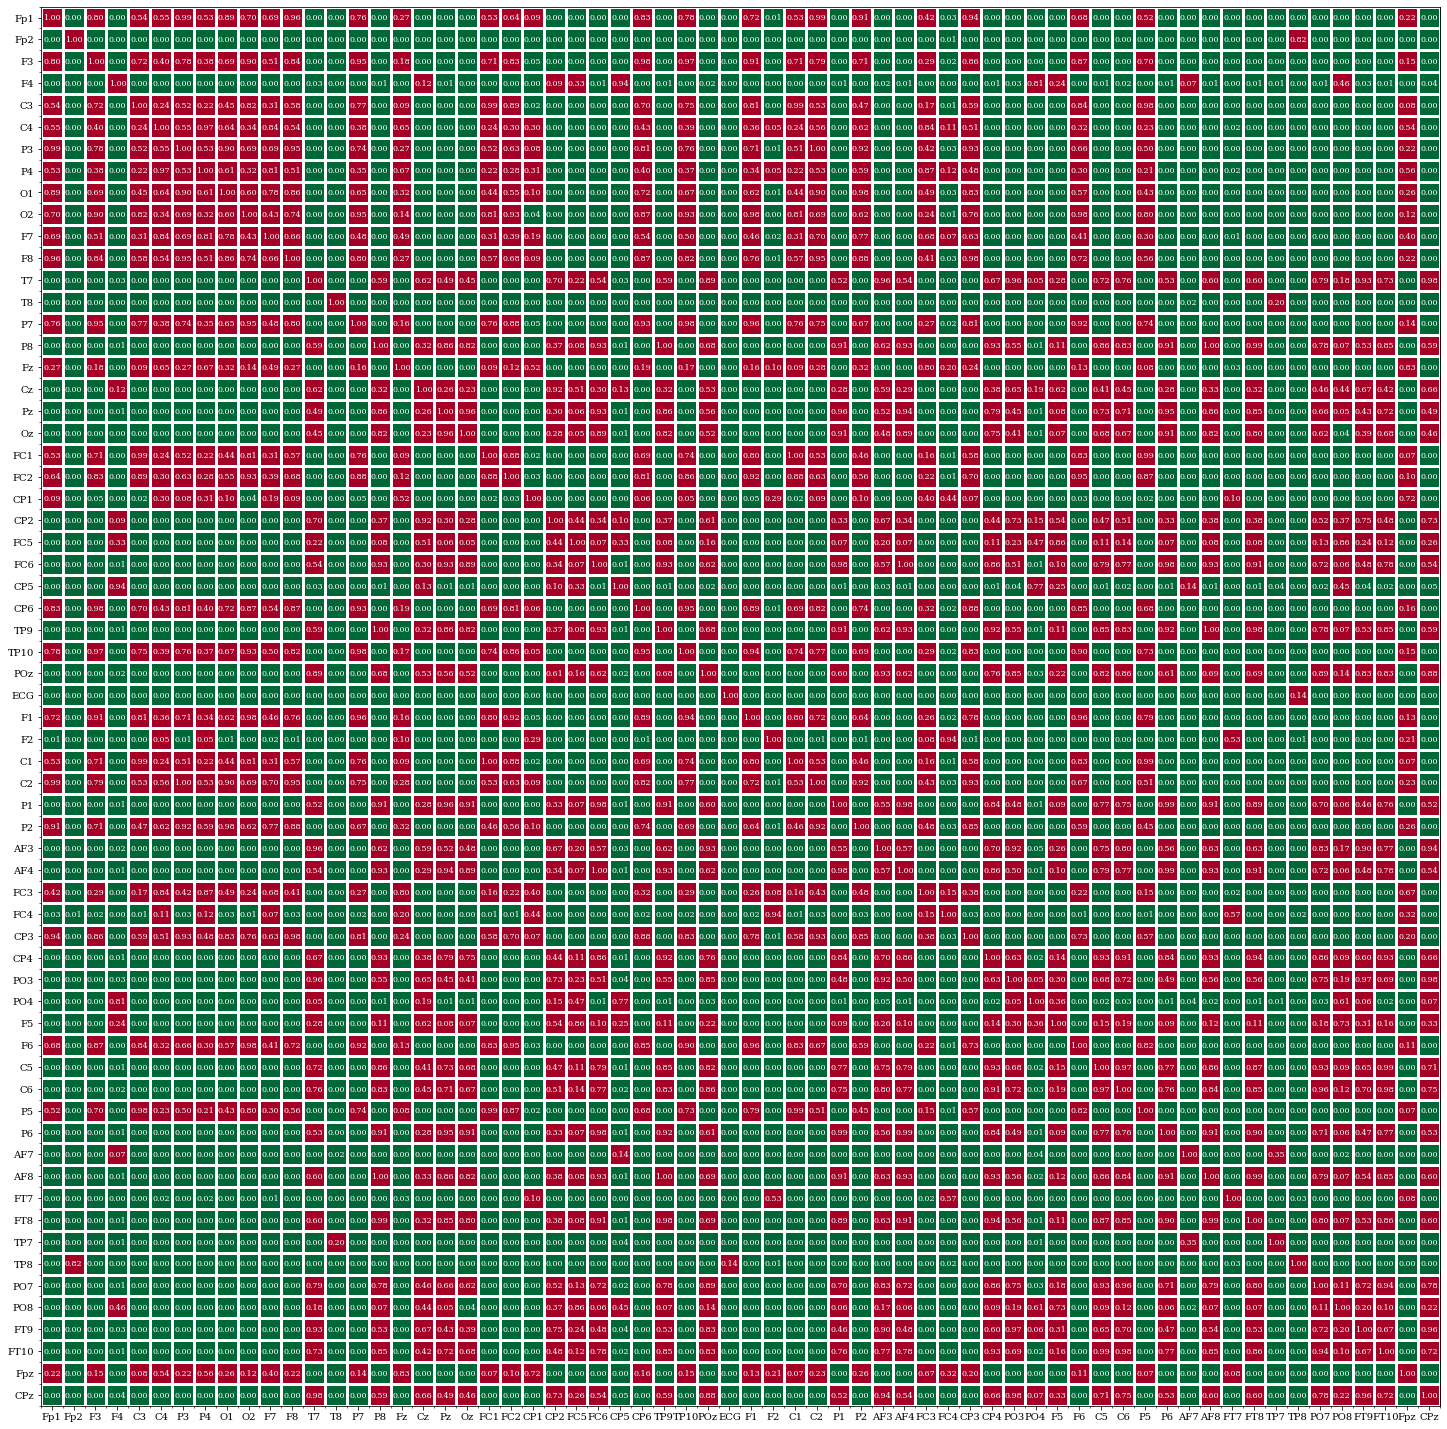

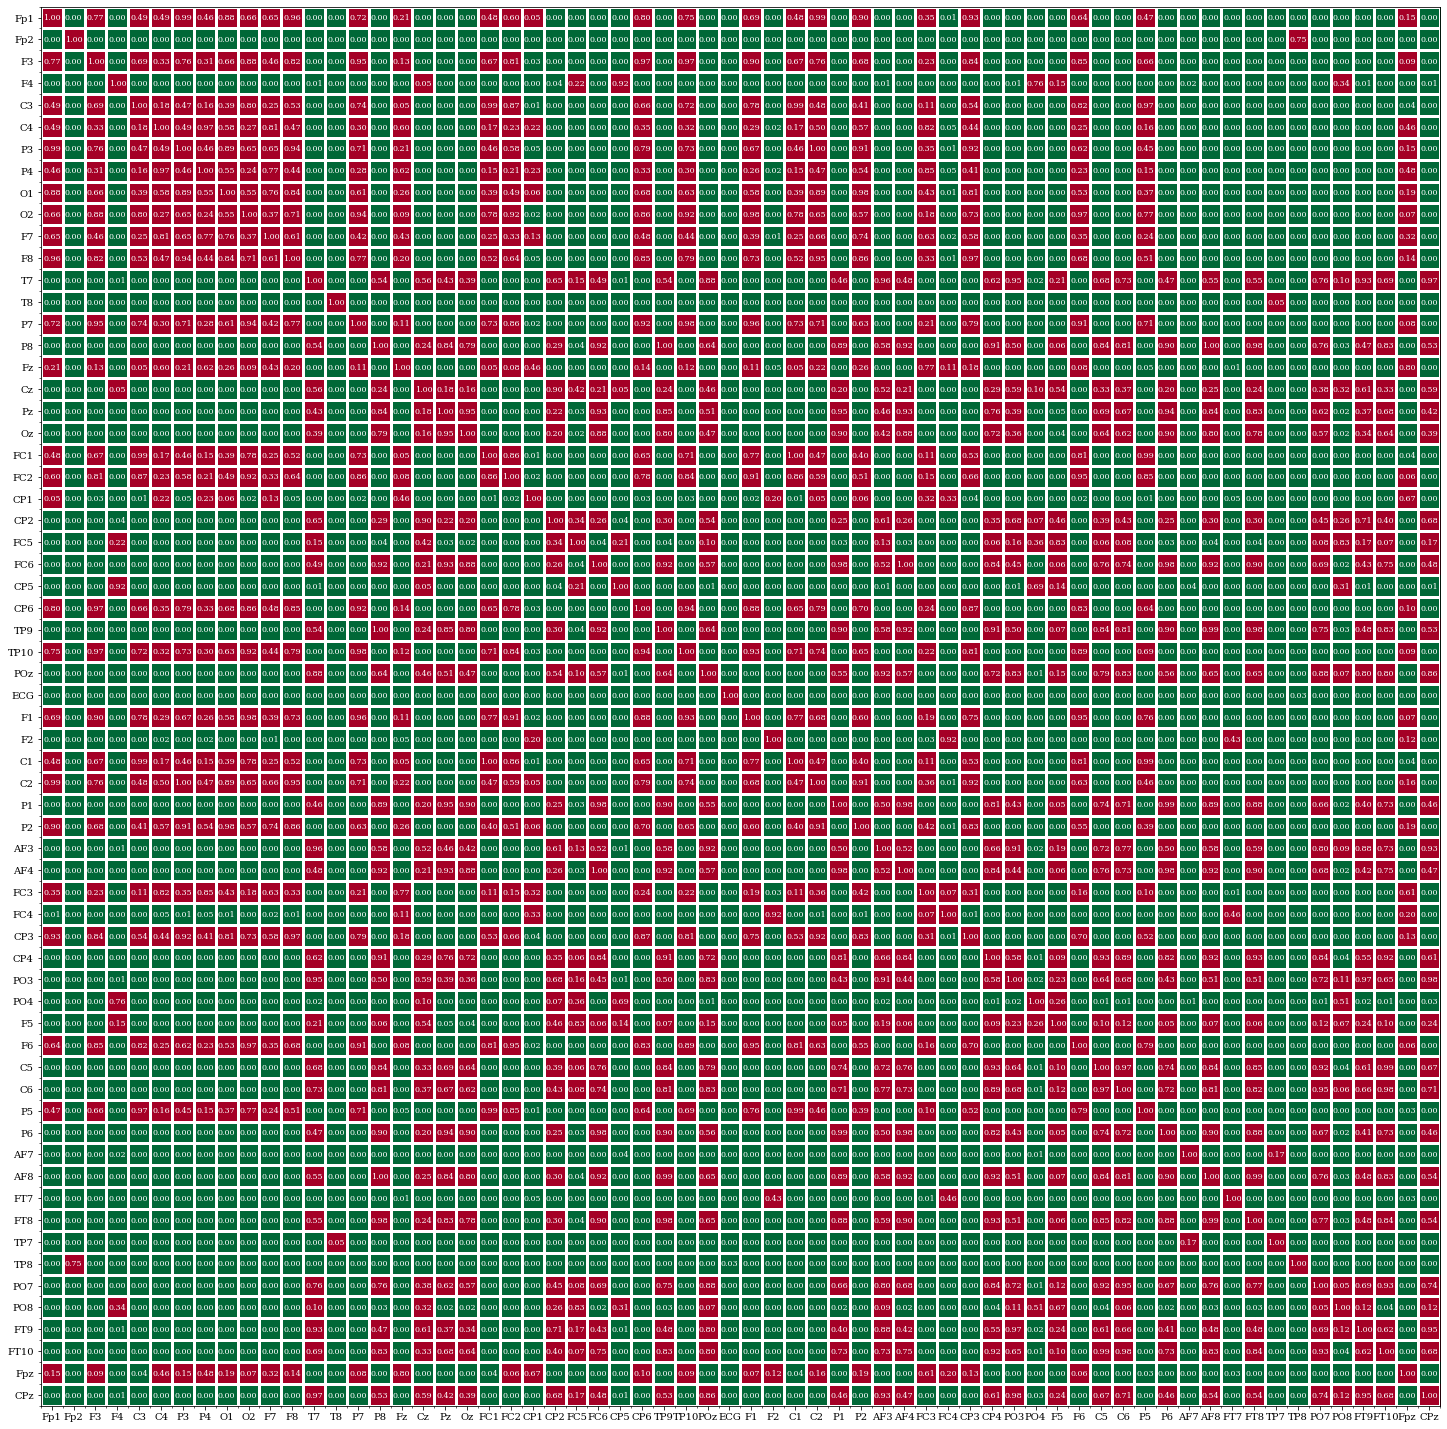

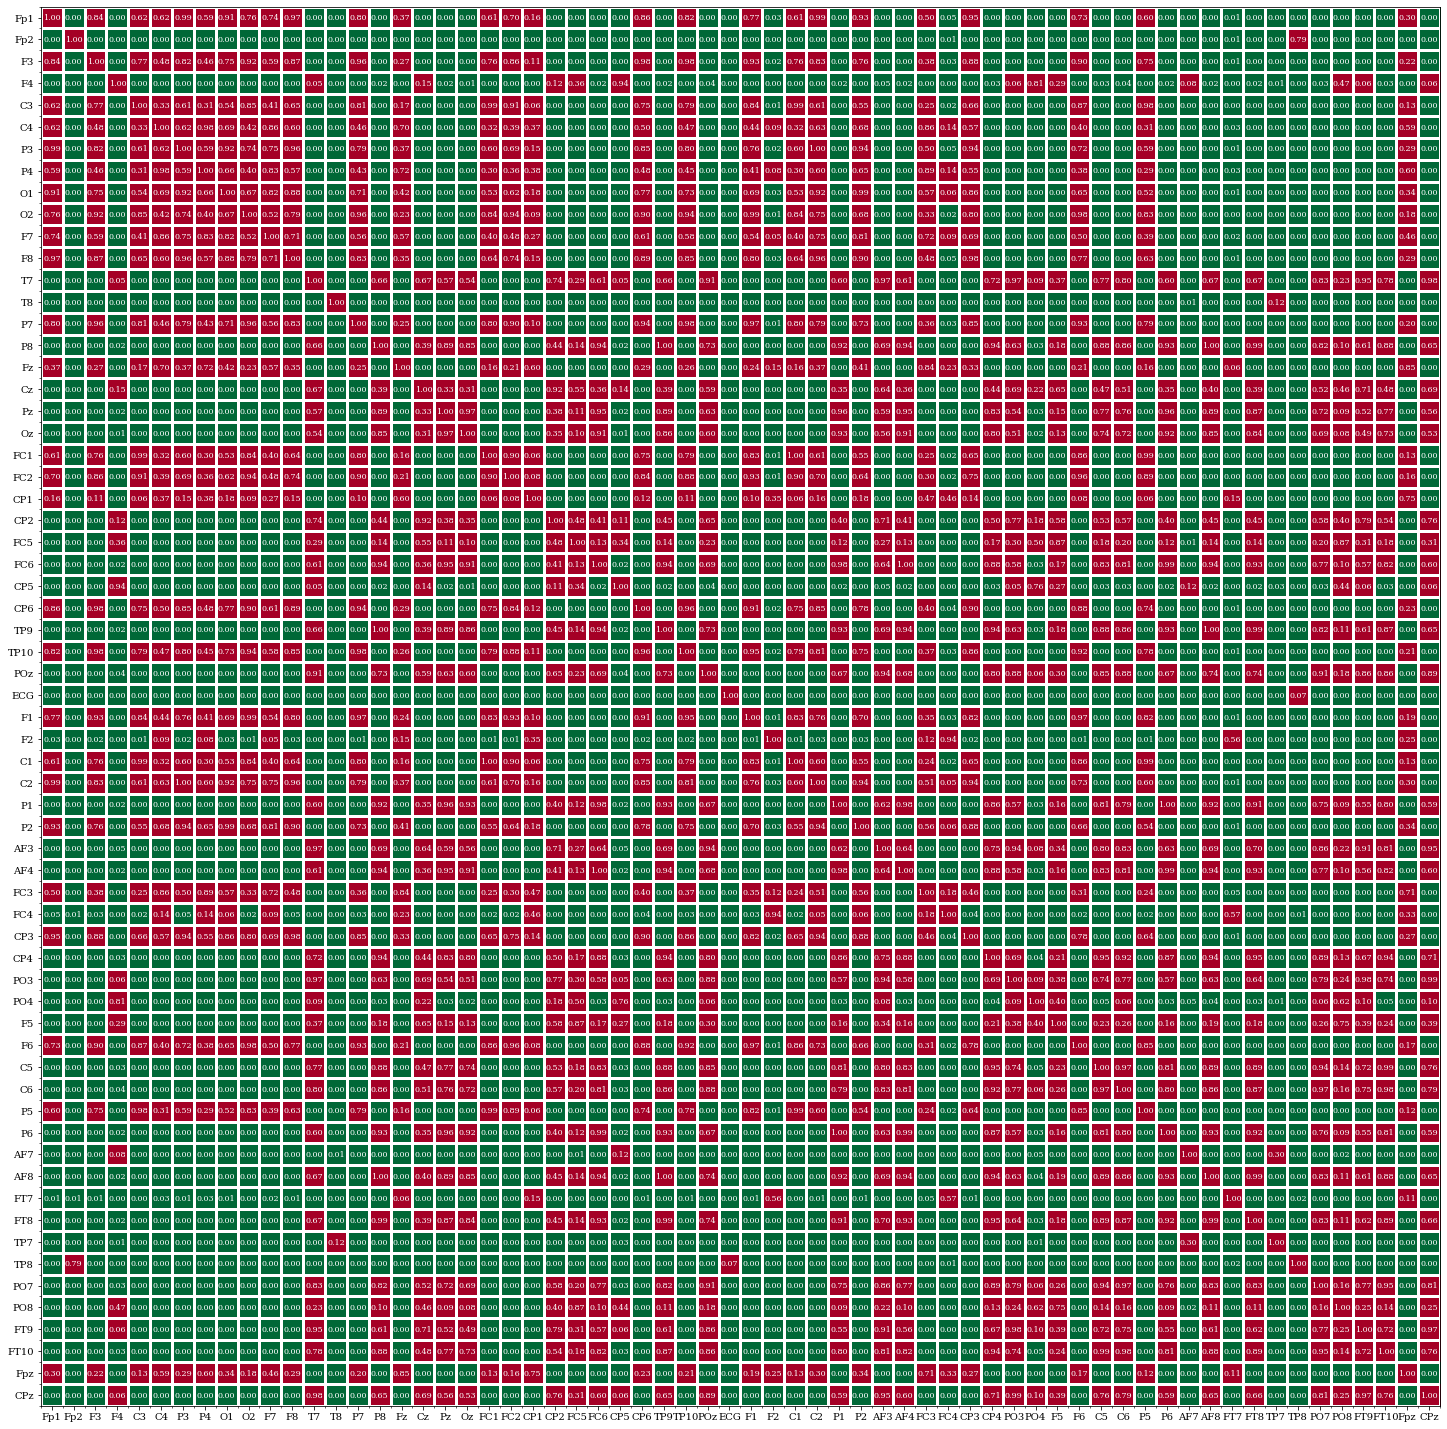

In [11]:
axis=["xaxis", "yaxis", "zaxis"]

for a in range(pvalue_img_pixels.shape[0]):

    fg = plt.figure(figsize=(20,20))
    ax = plt.gca()

    img = ax.imshow(pvalue_img_pixels[a], cmap="RdYlGn")

    plt.xticks(np.arange(0,len(channel_names)), channel_names)
    plt.yticks(np.arange(0,len(channel_names)), channel_names)

    ax.set_xticks(np.arange(len(channel_names)+1)-.5, minor=True)
    ax.set_yticks(np.arange(len(channel_names)+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)

    plt.tick_params(top=False, bottom=True,
                       labeltop=False, labelbottom=True)

    for i in range(pvalue_img[a,:,:].shape[0]):
        for j in range(pvalue_img[a,:,:].shape[1]):
            img.axes.text(j-0.40, i+0.1, "{:.2f}".format(pvalue_img[a, i, j]), fontsize=8,
                          color="white")

    plt.rc('font', family='serif')
    plt.tight_layout()

    if(dataset == "01"):
        fg.savefig("../../plots/stat_analysis/"+analysis_setting+"_"+axis[a]+"_"+resample_setting[int(resampling)]+"_pvalues_violin_channels_ds000001.pdf", format="pdf")
    elif(dataset == "02"):
        fg.savefig("../../plots/stat_analysis/"+analysis_setting+"_"+axis[a]+"_"+resample_setting[int(resampling)]+"_pvalues_violin_channels_ds000002.pdf", format="pdf")
    else:
        fg.savefig("../../plots/stat_analysis/"+analysis_setting+"_"+axis[a]+"_"+resample_setting[int(resampling)]+"_pvalues_violin_channels_ds002158.pdf", format="pdf")